In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import torch as th
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config

device = th.device("mps") if th.backends.mps.is_available() else th.device("cuda") if th.cuda.is_available() else th.device("cpu")

if device.type == "cuda":
    print(th.cuda.get_device_name(device))
else:
    print(device)


mps


In [2]:
data_dir = "datasets/"

# Dataset paths
full_path = data_dir + "full/" # Use this for full dataset that contains all review matadata
data_pruned = data_dir + "pruned/" # Only datasets with two numbers beside the path have a pruned version

full = "All_Amazon_Review_5.json" # 80 GB
arts = "Arts_Crafts_and_Sewing.json" # 629 MB / 1.18 GB
video = "Amazon_Instant_Video_5.json" # 28 MB

# Pruned dataset paths

# Read data with pandas
df = pd.read_json(data_pruned + arts, lines=True)

In [3]:
""" Prune a dataframe to only contain the columns we need """
# Drop all rows without a reviewtext or summary
""" df = df.dropna(subset=["reviewtext", "summary", "overall"])

# Write reviewtext, summary or overall to json file
df[["reviewtext", "summary", "overall"]].to_json("Pruned_Arts_Crafts_and_Sewing.json", orient="records", lines=True) """

' df = df.dropna(subset=["reviewtext", "summary", "overall"])\n\n# Write reviewtext, summary or overall to json file\ndf[["reviewtext", "summary", "overall"]].to_json("Pruned_Arts_Crafts_and_Sewing.json", orient="records", lines=True) '

In [5]:
# Tokenize reviewtext and summary
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize reviewtext
df["reviewtext"] = df["reviewtext"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Tokenize summary
df["summary"] = df["summary"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

df.head()

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1127 > 1024). Running this sequence through the model will result in indexing errors


,reviewtext,summary,overall
0,"[40, 1053, 1100, 428, 1492, 1541, 290, 314, 10...","[32, 220, 370, 1340, 14418, 46476, 39633]",5
1,"[35284, 306, 3194, 11678, 13]",[35284],5
2,"[23205, 340]","[20029, 10271]",5
3,"[10248, 3224, 41577, 4941, 284, 423, 1695, 287...","[10248, 20984, 287, 27114, 5061]",5
4,"[32, 308, 1031, 1131, 3912, 28096, 11, 45464, ...","[36716, 306, 1598, 11, 9321]",5


In [7]:
# Lower case all strings
#df.columns = map(str.lower, df.columns)

# Keep only the review text, rating, and summary
#df = df[['reviewtext', 'overall', 'summary']]

# Find max length of review text with numpy
max_review_len = np.max(df['reviewtext'].apply(len))
print("\nMax length of review text: ", max_review_len)
# Find max length of summary with numpy
max_summary_len = np.max((df['summary'].apply(len)))
print("Max length of summary: ", max_summary_len)


Max length of review text:  7273
Max length of summary:  81


KeyError: 0

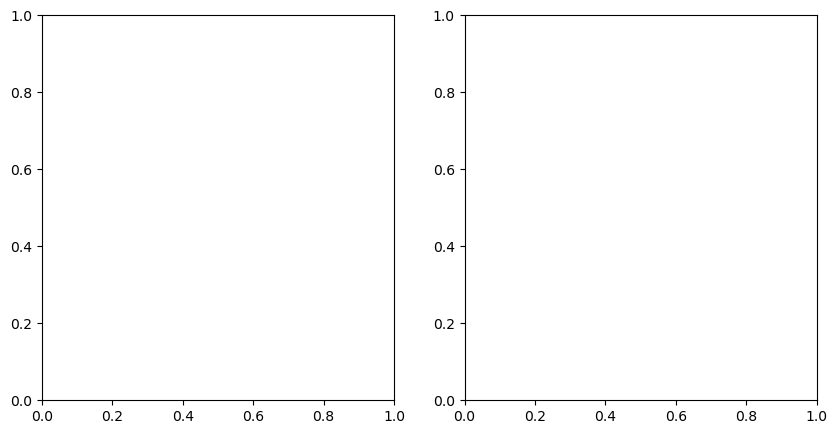

In [34]:
# Plot a distribution of review lengths with log scale
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

r_counts, r_bins = np.histogram(df['reviewtext'].apply(len), bins=100)
s_counts, s_bins = np.histogram(df['summary'].apply(len), bins=100)

r_counts = df['summary'].apply(len).value_counts()
print(r_counts)

print(s_bins)
print(s_counts)

print(len(r_counts), len(r_bins), len(s_counts), len(s_bins))

ax[0].hist(df['reviewtext'].apply(len), bins=100, log=True)
ax[0].set_title("Distribution of review lengths")
ax[0].set_xlabel("Review length")
ax[0].set_ylabel("Frequency")
ax[0].set_yscale("log")

ax[1].hist(df['summary'].apply(len), bins=100, log=True)
ax[1].set_title("Distribution of summary lengths")
ax[1].set_xlabel("summary length")
ax[1].set_ylabel("Frequency")
plt.show()

In [4]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices
# beware of symbols like ., !, ? etc.
# pad the review text and summary to max_review_len and max_summary_len respectively

class ReviewDataset(th.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df.iloc[idx, 0].split()
        review = [self.vocab2idx[word] for word in review]
        review = th.tensor(review, dtype=th.long)
        review = th.nn.functional.pad(review, (0, max_review_len - len(review)))
        rating = self.df.iloc[idx, 1]
        rating = th.tensor(rating, dtype=th.long)
        summary = self.df.iloc[idx, 2].split()
        summary = [self.vocab2idx[word] for word in summary]
        summary = th.tensor(summary, dtype=th.long)
        summary = th.nn.functional.pad(summary, (0, max_summary_len - len(summary)))

        # move tensors to device
        review = review.to(device)
        rating = rating.to(device)
        summary = summary.to(device)
        
        return review, rating, summary

In [6]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices

In [8]:
# test the dataset
dataset = ReviewDataset(df)
print(dataset[0])

TypeError: new(): invalid data type 'str'

In [ ]:
"""
Model
uses context aware word embedding
multi-task network

Input: takes in a review string
Task 1: output a summary string of the input review with a max length defined by the dataset
Task 2: output a rating of the input review as a float 0-1

Use an encoder decoder setup with one decoder for each task
"""
class Summariser(th.nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_review_len, max_summary_len):
        super(Summariser, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_review_len = max_review_len
        self.max_summary_len = max_summary_len
        self.embedding = th.nn.Embedding(vocab_size, embedding_dim)
        self.encoder = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder1 = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, batch_first=True)
        self.decoder2 = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, batch_first=True)
        self.linear1 = th.nn.Linear(embedding_dim, vocab_size)
        self.linear2 = th.nn.Linear(embedding_dim, 1)
        self.softmax = th.nn.Softmax(dim=2)
        self.sigmoid = th.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.encoder(x)
        x1, _ = self.decoder1(x)
        x2, _ = self.decoder2(x)
        x1 = self.linear1(x1)
        x1 = self.softmax(x1)
        x2 = self.linear2(x2)
        x2 = self.sigmoid(x2)
        return x1, x2

In [ ]:
"""
Dataset preparation
Use the ReviewDataset to create a DataLoader
Splitting the train, validation, and test sets
"""
# initialise the dataset
dataset = ReviewDataset(df)
dataset_size = len(dataset)

# shrink dataset for testing
dataset_size = 500
dataset = th.utils.data.Subset(dataset, range(dataset_size))

# split the dataset
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = th.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create the dataloaders
batch_size = 32
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = th.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# test the dataloader
train_loader_iter = iter(train_loader)
x, y, z = next(train_loader_iter)
print(x.shape, y.shape, z.shape)


torch.Size([32, 18152]) torch.Size([32]) torch.Size([32, 151])


In [ ]:
"""
Training
"""
""" # initialise the model
# take into account if it is a subset of the dataset
model = Summariser(dataset.dataset.vocab_size, 256, max_review_len, max_summary_len)
model = model.to(device)

# define the loss functions
loss_fn1 = th.nn.CrossEntropyLoss()
loss_fn2 = th.nn.BCELoss()

# define the optimiser
optimiser = th.optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
epochs = 10

# train the model
for epoch in range(epochs):
    for review, rating, summary in train_loader:
        # zero the gradients
        optimiser.zero_grad()

        # forward pass
        y_pred1, y_pred2 = model(review)

        # calculate the loss
        loss1 = loss_fn1(y_pred1, summary)
        loss2 = loss_fn2(y_pred2, rating.unsqueeze(1).float())
        loss = loss1 + loss2

        # backward pass
        loss.backward()

        # update the weights
        optimiser.step()

    # print the loss
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}') """
